<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Alireza Shokrani
### Student ID: 99106255

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 86559801.22it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105152512.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30174177.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17541923.36it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

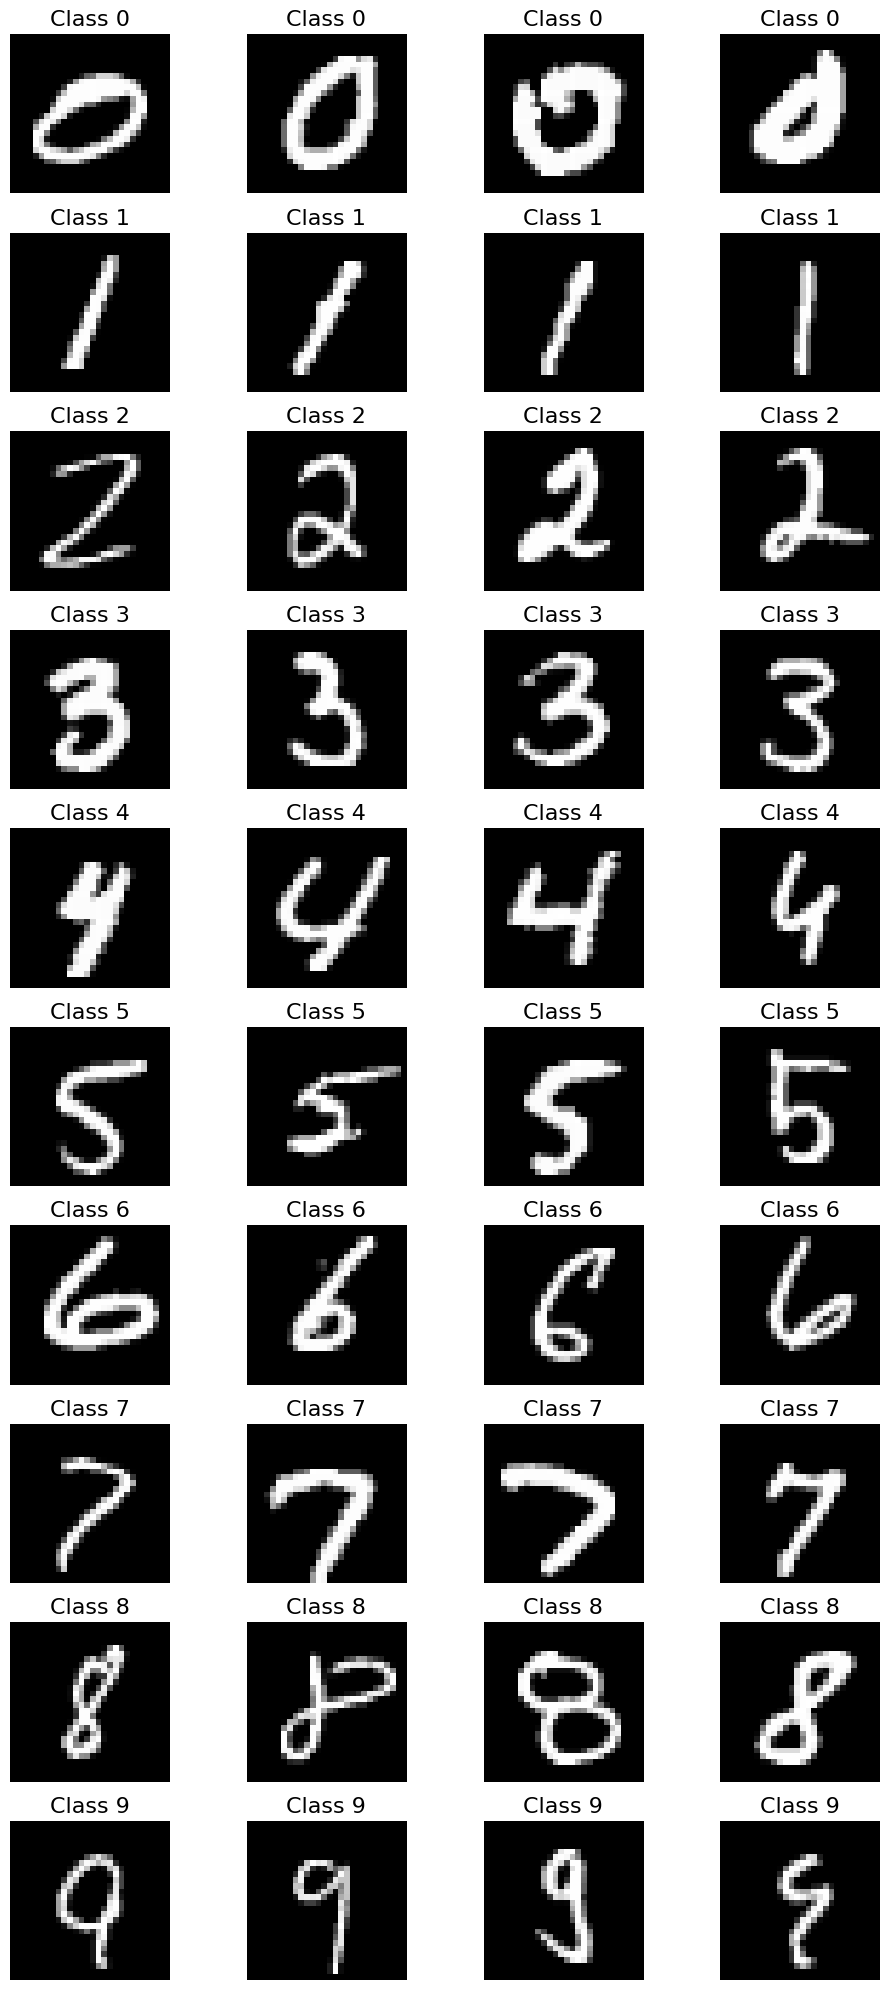

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Implement the forward pass
        # Encode
        x = self.encoder(x)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.reparameterize(mu, logvar)

        # Decode
        recon = self.decoder(z)

        return recon, mu, logvar

In [6]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_divergence
    return total_loss

In [7]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Forward process

            # Flatten the data and recon tensors
            data = data.view(-1, 28 * 28)
            recon, mu, logvar = model(data)

            # Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 176.25448911946614
Sample Images:


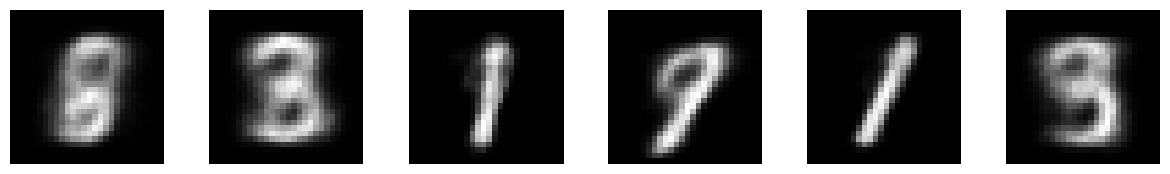


##################################################
VAE-MLP Epoch [2/10], Loss: 156.9259763346354
Sample Images:


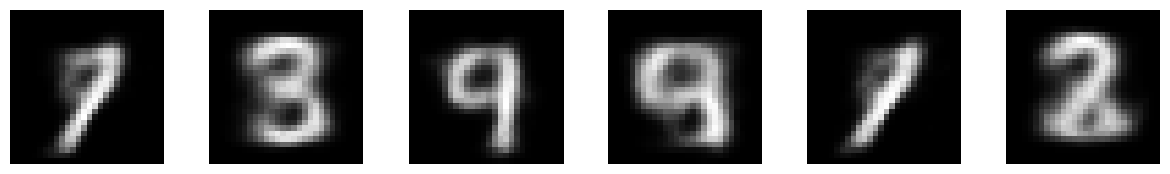


##################################################
VAE-MLP Epoch [3/10], Loss: 152.21267388509114
Sample Images:


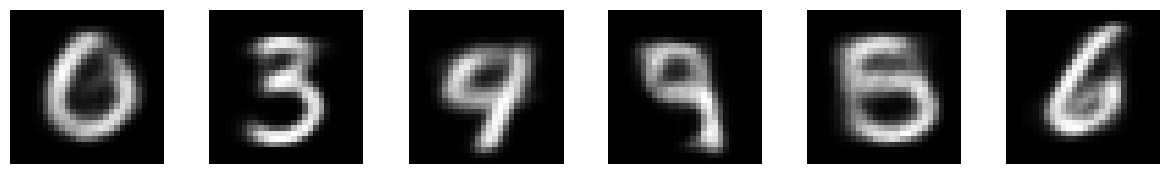


##################################################
VAE-MLP Epoch [4/10], Loss: 149.929721492513
Sample Images:


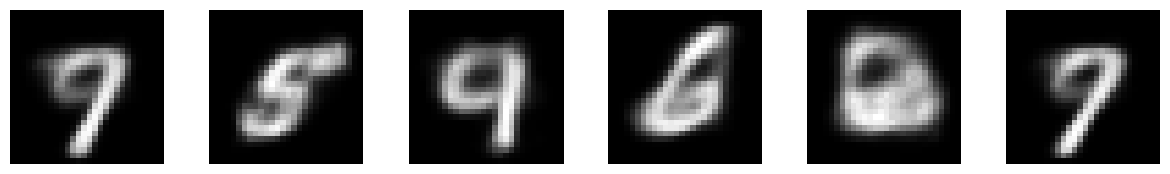


##################################################
VAE-MLP Epoch [5/10], Loss: 148.3294636311849
Sample Images:


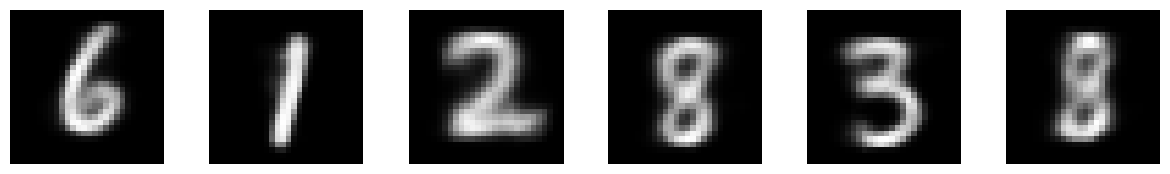


##################################################
VAE-MLP Epoch [6/10], Loss: 146.75165476074218
Sample Images:


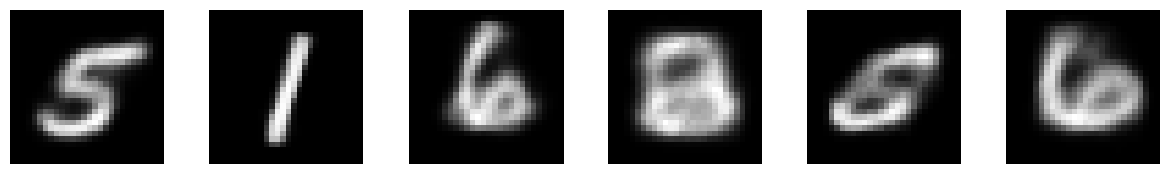


##################################################
VAE-MLP Epoch [7/10], Loss: 145.6522250406901
Sample Images:


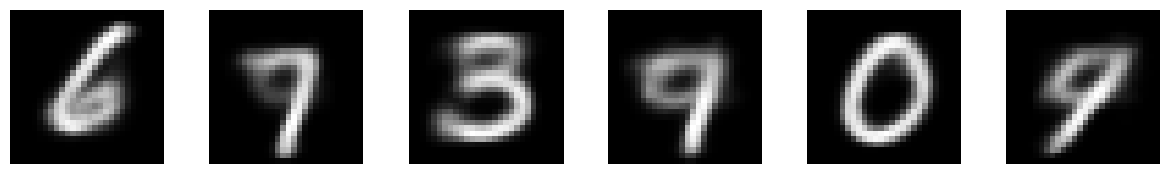


##################################################
VAE-MLP Epoch [8/10], Loss: 144.7589404622396
Sample Images:


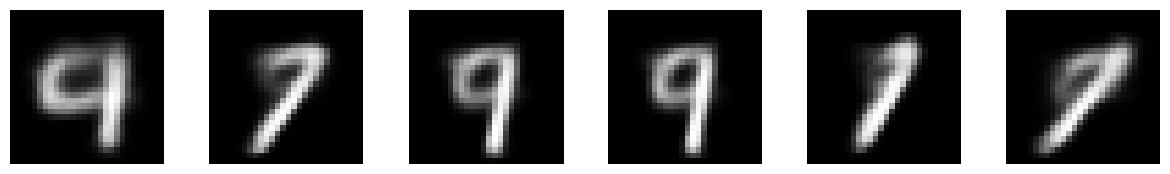


##################################################
VAE-MLP Epoch [9/10], Loss: 144.0367748779297
Sample Images:


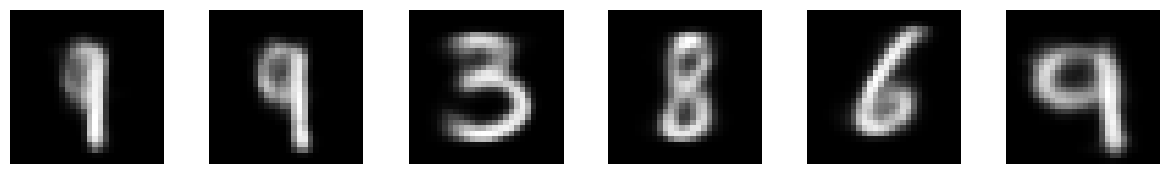


##################################################
VAE-MLP Epoch [10/10], Loss: 143.58137796223957
Sample Images:


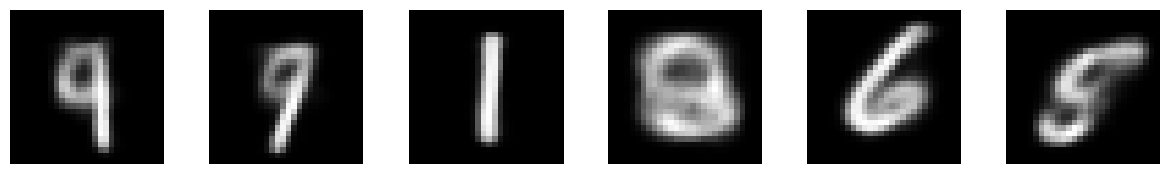

Best model saved as 'best_vae_mlp_model.pth'


In [8]:
# Train VAE-MLP
vae_mlp = vae_mlp = VAE_MLP(input_dim=28*28, hidden_dim=300, latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [9]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)

        # Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        # Concatenate z and y before passing them to the decoder
        z_y = torch.cat([z, y], dim=1)

        reconstructed = self.decoder(z_y)

        return reconstructed, mu, logvar, class_logits


In [10]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(-1, 28 * 28)

    # Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels)

    # Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss


In [11]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 159.33595111490885
Sample Images:


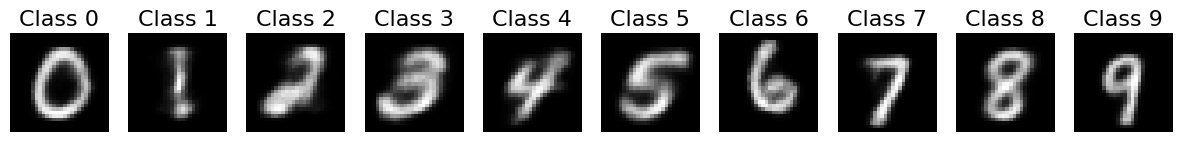


##################################################
CVAE-MLP Epoch [2/10], Loss: 138.13739759114583
Sample Images:


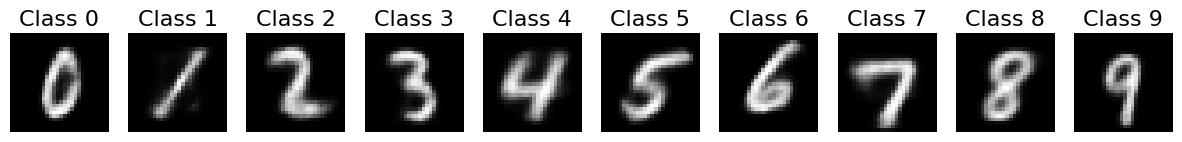


##################################################
CVAE-MLP Epoch [3/10], Loss: 135.05770946451824
Sample Images:


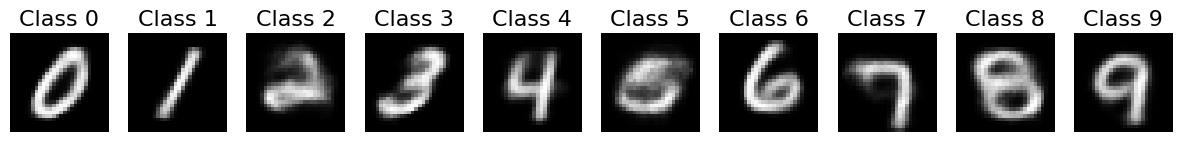


##################################################
CVAE-MLP Epoch [4/10], Loss: 133.53963475748697
Sample Images:


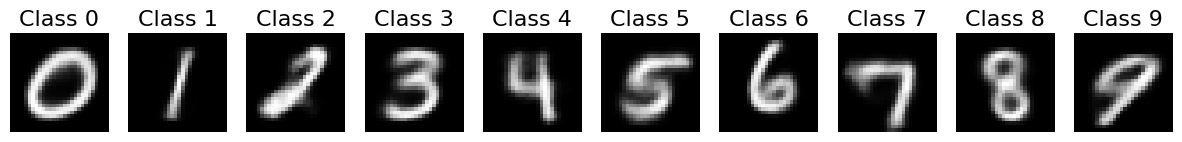


##################################################
CVAE-MLP Epoch [5/10], Loss: 132.6090798461914
Sample Images:


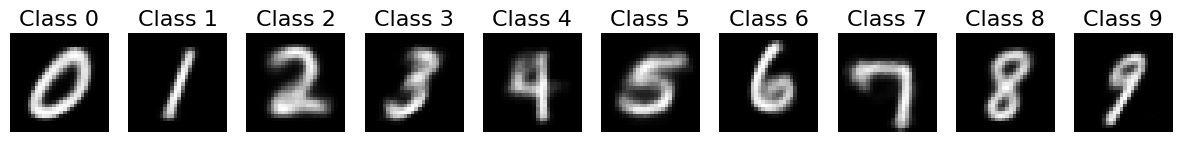


##################################################
CVAE-MLP Epoch [6/10], Loss: 131.8251200439453
Sample Images:


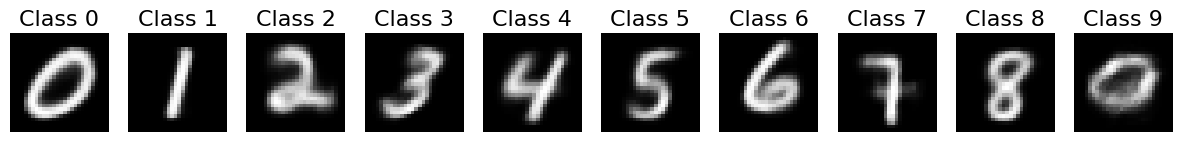


##################################################
CVAE-MLP Epoch [7/10], Loss: 131.19709208984375
Sample Images:


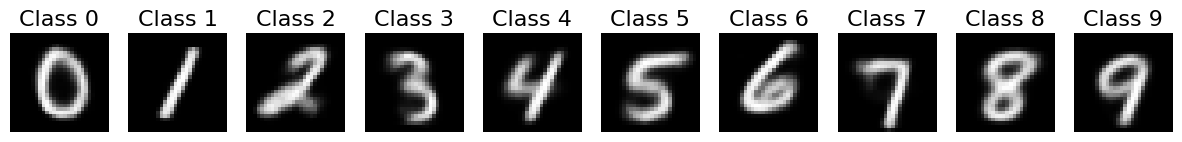


##################################################
CVAE-MLP Epoch [8/10], Loss: 130.68489402669272
Sample Images:


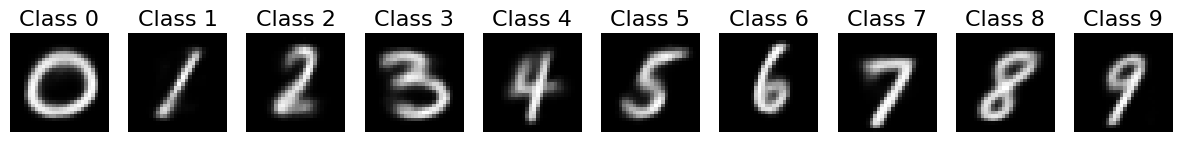


##################################################
CVAE-MLP Epoch [9/10], Loss: 130.2461032877604
Sample Images:


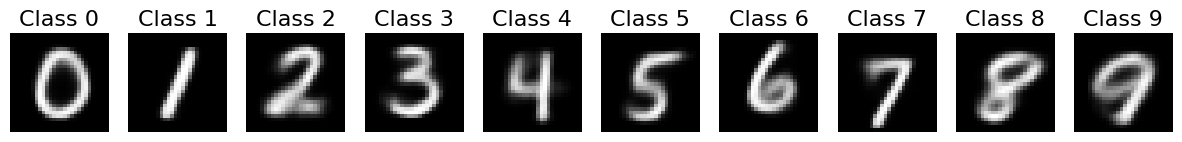


##################################################
CVAE-MLP Epoch [10/10], Loss: 129.85198935546876
Sample Images:


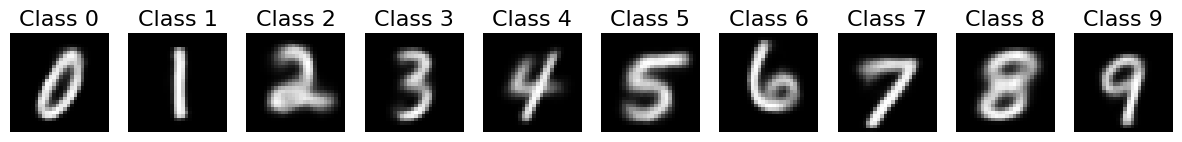

Best model saved as 'best_cvae_mlp_model.pth'


In [12]:
cvae_mlp = CVAE_MLP(input_dim=28*28, hidden_dim=300, latent_dim=2, num_classes=10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


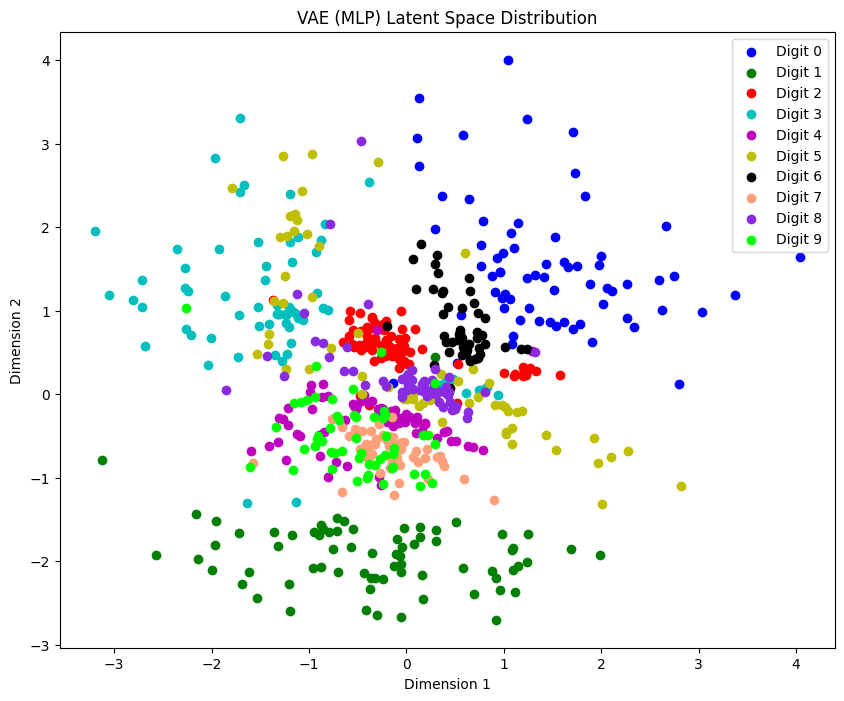

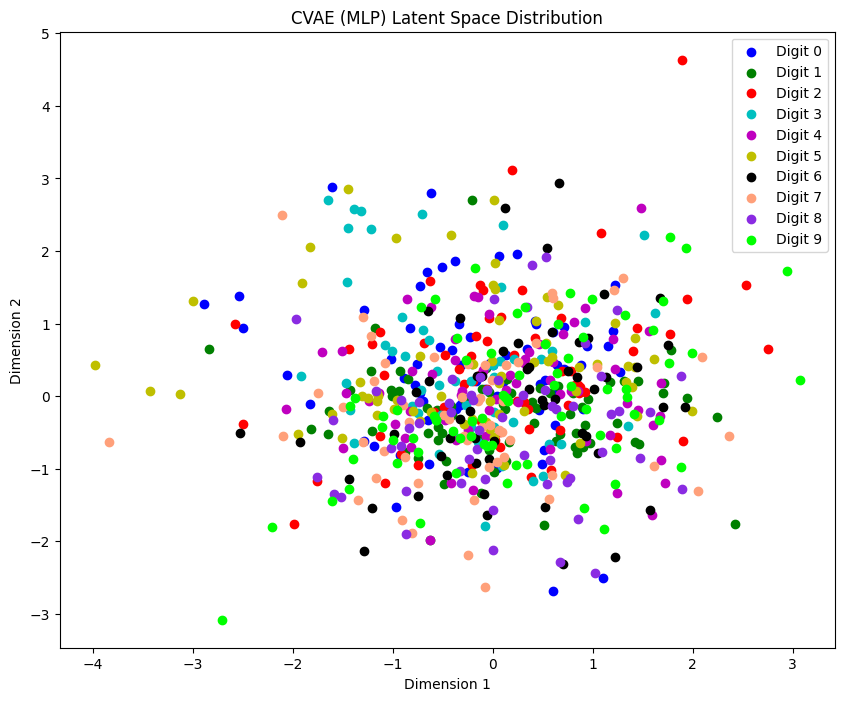

In [39]:
def visualize_latent_space(model, dataloader, num_batches=10, title='Latent Space Distribution', Conditioned=False):
    model.eval()
    latent_space = torch.zeros(0,2)
    latent_labels = torch.zeros(0,1)
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break
            if Conditioned:
                labels_one_hot = F.one_hot(labels, num_classes=10).float()
                _, mu, _, _ = model(data, labels_one_hot)
            else:
                data = data.view(-1, 28 * 28)
                _, mu, _ = model(data)

            latent_space = torch.vstack((latent_space,mu))
            latent_labels = torch.vstack((latent_labels,labels.view(-1, 1)))

    latent_space_np = latent_space.numpy()
    latent_labels_np = latent_labels.numpy()

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA07A', '#8A2BE2', '#00FF00']
    plt.figure(figsize=(10, 8))
    for i in range(10):
        indices = np.where(latent_labels_np == i)[0]
        plt.scatter(latent_space_np[indices, 0], latent_space_np[indices, 1], label=f'Digit {i}', color=colors[i])


    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

# Visualize Latent Space Distribution for VAE (MLP)
visualize_latent_space(vae_mlp, train_loader, title='VAE (MLP) Latent Space Distribution', Conditioned=False)

# Visualize Latent Space Distribution for CVAE (MLP)
visualize_latent_space(cvae_mlp, train_loader, title='CVAE (MLP) Latent Space Distribution',  Conditioned=True)

We see that in simple VAE the digit classes are much more separated from each other. It is because the latent space is the only information that is given to the encoder so it learns to use spatial information of latent vector for generating different digits. On the other hand, in CVAE there is an additional piece of information that shows the vector belongs to which class, so the need for spatial separation is less intense and the encoder instead learns to map the pictures to a space that is better for generating pictures with better quality instead of focusing on learning the difference between digits. That’s also why the images generated using CVAE seems to have more quality in general.